<a target="_blank" href="https://colab.research.google.com/github/eeg2025/startkit/blob/main/challenge_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Challenge 1: Cross-Task Transfer Learning!

## How can we use the knowledge from one EEG Decoding task into another?

Transfer learning is a widespread technique used in deep learning. It uses knowledge learned from one source task/domain in another target task/domain. It has been studied in depth in computer vision, natural language processing, and speech, but what about EEG brain decoding?

The cross-task transfer learning scenario in EEG decoding is remarkably underexplored in comparison to the developers of new models, [Aristimunha et al., (2023)](https://arxiv.org/abs/2308.02408), even though it can be much more useful for real applications, see [Wimpff et al. (2025)](https://arxiv.org/abs/2502.06828), [Wu et al. (2025)](https://arxiv.org/abs/2507.09882).

Our Challenge 1 addresses a key goal in neurotechnology: decoding cognitive function from EEG using the pre-trained knowledge from another. In other words, developing models that can effectively transfer/adapt/adjust/fine-tune knowledge from passive EEG tasks to active tasks.

The ability to generalize and transfer is something critical that we believe should be focused. To go beyond just comparing metrics numbers that are often not comparable, given the specificities of EEG, such as pre-processing, inter-subject variability, and many other unique components of this type of data.

This means your submitted model might be trained on a subset of tasks and fine-tuned on data from another condition, evaluating its capacity to generalize with task-specific fine-tuning.

__________

Note: For simplicity purposes, we will only show how to do the decoding directly in our target task, and it is up to the teams to think about how to use the passive task to perform the pre-training.

| The tutorial assumes some prior knowledge of deep learning concepts and EEG concepts:|
| --- |
|* Standard neural network architectures, e.g., convolutional neural networks|
|* Optimization by batch gradient descent and backpropagation|
|* Overfitting, early stopping, regularisation |
|* Some knowledge of pytorch and, optionally, of the pytorch Lightning framework|
|* That you know what EEG is |
|* That you have basic familiarity with EEG preprocessing |
|* Like and support open-source :) |

**NOTE: You will still be able to run the whole notebook at your own pace and learn about these concepts along the way**
**NOTE: If you just want run the code and start to play, please go to the challenge version 1, clean in the folder**

----

---
## Summary table for this start kit

In this tutorial, we are going to show in more detail what we want from Challenge 1:

**Contents**:

0. Understand the Contrast Change Detection - CCD task.
1. Understand the [`EEGChallengeDataset`](https://eeglab.org/EEGDash/api/eegdash.html#eegdash.EEGChallengeDataset) object.
2. Preparing the dataloaders.
3. Building the deep learning model with [`braindecode`](https://braindecode.org/stable/models/models_table.html).
4. Designing the training loop.
5. Training the model.
6. Evaluating test performance.
7. Going further, *benchmark go brrr!*



More contents will be released during the competition inside the [`eegdash`](https://eeglab.org/EEGDash/overview.html) [examples webpage](https://eeglab.org/EEGDash/generated/auto_examples/index.html).

We will establish direct communication channels with you over the next two months, resolve platform issues, and discuss other details.

We are going to do weekly one-hour support time to help teams that may have difficulties with any technical aspects that may arise.

We will have closer communication starting next week, 08/09/2025.

Before we begin, I just want to make a deal with you, ok?

This is a community competition with a strong open-source foundation. When I say open-source, I mean volunteer work.

So, if you see something that does not work or could be improved, first, **please be kind**, and we will fix it together on GitHub, okay?

The entire decoding community will only go further when we stop solving the same problems over and over again, and it starts working together.

----

⚠️ **In case of colab, before starting, make sure you're on a GPU instance for faster training!** ⚠️

> If running on Google Colab, please request a GPU runtime by clicking `Runtime/Change runtime type` in the top bar menu, then selecting 'T4 GPU' under 'Hardware accelerator'.

In [ ]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

CUDA-enabled GPU found. Training should be faster.


For the challenge, we will need two significant dependencies: `braindecode` and `eegdash`. The libraries will install PyTorch, Pytorch Audio, Scikit-learn, MNE, MNE-BIDS, and many other packages necessary for the many functions.

In [ ]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 153.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.

## 1. What are we decoding?

To start to talk about what we want to analyse, the important thing is to understand some basic concepts.

-----

# The brain decodes the problem

Broadly speaking, here *brain decoding* is the following problem: given brain time-series signals $X \in \mathbb{R}^{C \times T}$ with labels $y \in \mathcal{Y}$, we implement a neural network $f$ that **decodes/translates** brain activity into the target label.

We aim to translate recorded brain activity into its originating stimulus, behavior, or mental state, [King, J-R. et al. (2020)](https://lauragwilliams.github.io/d/m/CognitionAlgorithm.pdf).

The neural network $f$ applies a series of transformation layers (e.g., `torch.nn.Conv2d`, `torch.nn.Linear`, `torch.nn.ELU`, `torch.nn.BatchNorm2d`) to the data to filter, extract features, and learn embeddings relevant to the optimization objective—in other words:

$$
f_{\theta}: X \to y,
$$

where $C$ (`n_chans`) is the number of channels/electrodes and $T$ (`n_times`) is the temporal window length/epoch size over the interval of interest. Here, $\theta$ denotes the parameters learned by the neural network.


----

For the competition, the HBN-EEG (Healthy Brain Network EEG Datasets) dataset has `n_chans = 129` with the last channels as [reference channel](https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html), and we define the window length as `n_times = 200`, corresponding to 2-second windows.

Your model should follow this definition exactly; any specific selection of channels, filtering, or domain-adaptation technique must be performed **within the layers of the neural network model**.



If you are interested to get more neuroscience insight, we recommend these two refereces, [HBN-EEG](https://www.biorxiv.org/content/10.1101/2024.10.03.615261v2.full.pdf) and [ Langer, N et al. (2017)](https://www.nature.com/articles/sdata201740#Sec2)

Your task (**label**) is to predict the response time for the subject during this windows.

In the Video, we have an example of recording cognitive activity:

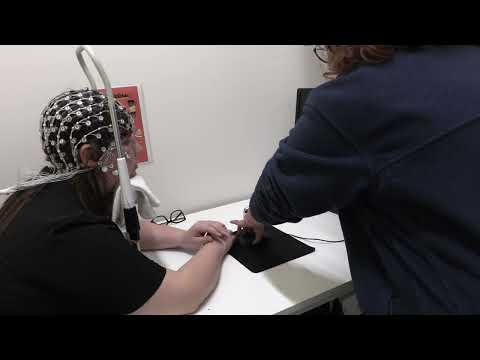

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("tOW2Vu2zHoU", start=1630, width=960, height=540)


In the figure below, we have the timeline representation of the cognitive task:

![https://eeg2025.github.io/assets/img/CCD_sequence.png](https://eeg2025.github.io/assets/img/image-2.jpg)


Now, talking about the code, we can start to use `eegdash`!

In [ ]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

from eegdash.dataset import EEGChallengeDataset

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R5", cache_dir=DATA_DIR,
                                  mini=True)


╭─────────────────────────────────────── EEG 2025 Competition Data Notice ────────────────────────────────────────╮
│ This object loads the HBN dataset that has been preprocessed for the EEG Challenge:                             │
│   * Downsampled from 500Hz to 100Hz                                                                             │
│   * Bandpass filtered (0.5-50 Hz)                                                                               │
│                                                                                                                 │
│ For full preprocessing applied for competition details, see:                                                    │
│   ]8;id=5561;https://github.com/eeg2025/downsample-datasets\https://github.com/eeg2025/downsample-datasets]8;;\                                                                │
│                                                                                                                 │
│ The HBN dataset have some preprocessing applied by the HBN team:                                                │
│   * Re-reference (Cz Channel)                                                                                   │
│                                                                                                                 │
│ IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from ]8;id=61933;https://github.com/sccn/EEGDash/blob/develop/eegdash/api.py\EEGDashDataset]8;;\     │
│ directly.                                                                                                       │
│ If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the    │
│ challenge data.                                                                                                 │
╰────────────────────────────────────────── Source: EEGChallengeDataset ──────────────────────────────────────────╯

In [ ]:
dataset_ccd

In [ ]:
dataset_ccd.datasets[0]

Now, we have a Pytorch Dataset object that contains the set of recordings for the task `contrastChangeDetection`.

This dataset object have very rich Raw object details that can help you to understand better the data. The framework behind this is braindecode, and if you want to understand in depth what is happening, we recommend the braindecode github itself.


If you want to load the whole release you need change the `mini=False`.

In [ ]:
# For visualization purposes, we will see just one object.

raw = dataset_ccd.datasets[0].raw  # get the Raw object of the first recording

In [ ]:
raw

<RawEDF | sub-NDARAH793FBF_task-contrastChangeDetection_run-1_eeg.bdf, 129 x 34900 (349.0 s), ~101 KiB, data not loaded>

Using matplotlib as 2D backend.


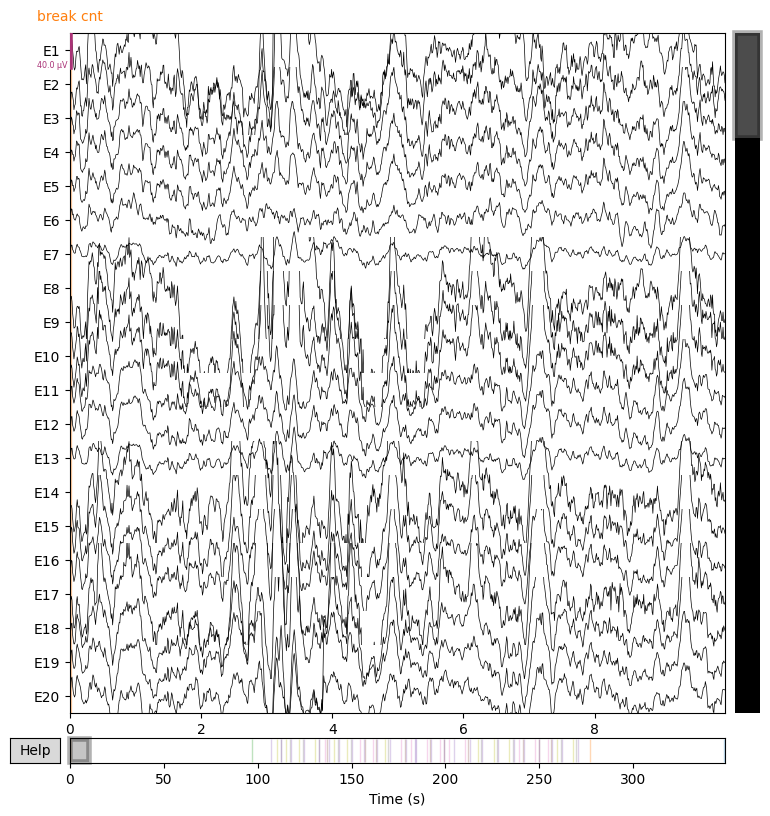

In [ ]:
fig = raw.plot()

As you just realized, the eeg dash dataset object will download the dataset only when necessary, and in this case, only when we want to consume the raw data. To download all data directly, we recommend downloading the versions with Amazon API, or doing something like:

In [ ]:
from joblib import Parallel, delayed

raws = Parallel(n_jobs=-1)(
    delayed(lambda d: d.raw)(d) for d in dataset_ccd.datasets
)

Using matplotlib as 2D backend.


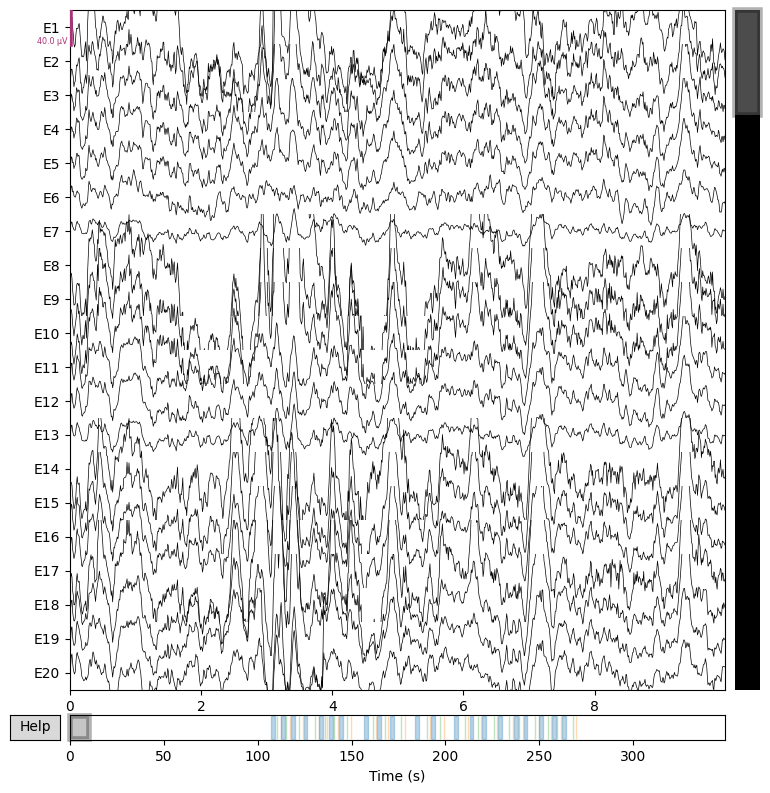

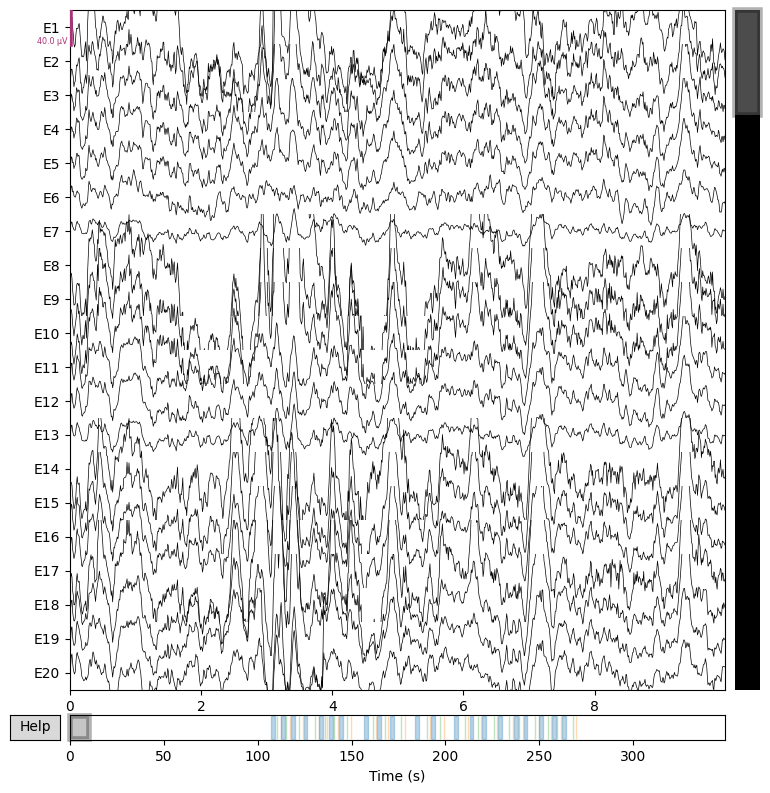

In [ ]:
raws[0].plot()

## 2. Creating the windows of interest

Now that we have our raw dataset, defining the windows/epoch interval is essential.

For this challenge, we test many different and semantically different regions of interest, and our preliminary studies show us that the most interesting area of interest is defined below:


*        stimulus         │        response         │        feedback
*                         │ *********************** (stimulus + 0.5)

So we epoch after the stimulus moment with a beginning shift of 500 ms.

In [ ]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset


So, on our raw data, we fit the events present in it, and create a window of interest.

In [ ]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

Now that we have our windowed data, we can split it into the different sets that are needed for modeling. Since our challenge focuses on generalization across subjects, we recommend dividing at the subject level.

(1) the training set is used to learn the parameters of our deep learning model,  

(2) the validation set is used to monitor the training process and decide when to stop it, and  

(3) the test set is used to provide an estimate of the generalization performance of our model.

Here, we use the last 10% of windows for testing, 10% for validation and split the remaining 80% of windows into training.

**Here we go into the steps that you and your team must validate to obtain better results**

In [ ]:
# for each windows, we can extract the metainformation using:

meta_information = single_windows.get_metadata()

In [ ]:
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,11056,11256,2.11,2.11,4.932,110.062,112.172,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,11579,11779,1.87,1.87,4.672,115.29,117.16,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,12259,12459,1.95,1.95,6.35,122.09,124.04,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,13099,13299,2.1,2.1,8.1,130.49,132.59,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,13619,13819,1.22,1.22,4.02,135.69,136.91,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


## You can inspect your target label doing:

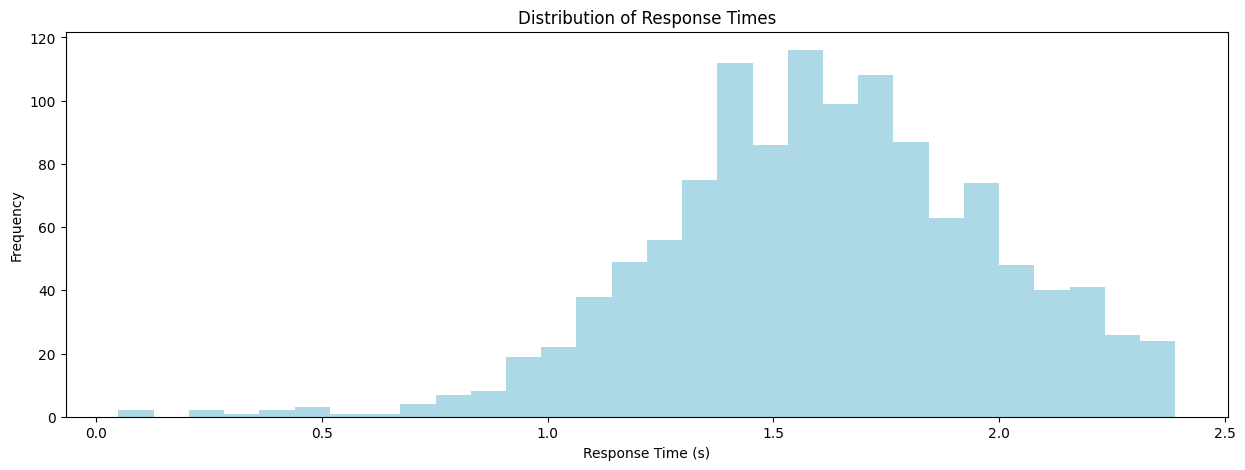

In [ ]:
from matplotlib.pylab import plt

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.1
test_frac = 0.1
seed = 2025

subjects = meta_information["subject"].unique()
sub_rm = ["NDARWV769JM7", "NDARME789TD2", "NDARUA442ZVF", "NDARJP304NK1",
          "NDARTY128YLU", "NDARDW550GU6", "NDARLD243KRE", "NDARUJ292JXV", "NDARBA381JGH"]
subjects = [s for s in subjects if s not in sub_rm]

train_subj, valid_test_subject = train_test_split(
    subjects, test_size=(valid_frac + test_frac), random_state=check_random_state(seed), shuffle=True
)

valid_subj, test_subj = train_test_split(
    valid_test_subject, test_size=test_frac, random_state=check_random_state(seed + 1), shuffle=True
)
# sanity check
assert (set(valid_subj) | set(test_subj) | set(train_subj)) == set(subjects)

In [ ]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	981
Valid:	183
Test:	50


Finally, we create pytorch `DataLoader`s, which will be used to feed the data to the model during training and evaluation:

In [ ]:
# Create datasets and dataloaders
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Building the deep learning model

For neural network models, **to start**, we suggest using [braindecode models](https://braindecode.org/1.2/models/models_table.html) zoo. We have implemented several different models for decoding the brain timeseries.

Your team's responsibility is to develop a PyTorch module that receives the three-dimensional (`batch`, `n_chans`, `n_times`) input and outputs the contrastive response time.

In [ ]:
from braindecode.models.util import models_dict

names = sorted(models_dict)
w = max(len(n) for n in names)

for i in range(0, len(names), 3):
    row = names[i:i+3]
    print("  ".join(f"{n:<{w}}" for n in row))

ATCNet                  AttentionBaseNet        AttnSleep             
BDTCN                   BIOT                    CTNet                 
ContraWR                Deep4Net                DeepSleepNet          
EEGConformer            EEGITNet                EEGInceptionERP       
EEGInceptionMI          EEGMiner                EEGNeX                
EEGNet                  EEGSimpleConv           EEGTCNet              
FBCNet                  FBLightConvNet          FBMSNet               
IFNet                   Labram                  MSVTNet               
SCCNet                  SPARCNet                ShallowFBCSPNet       
SignalJEPA              SignalJEPA_Contextual   SignalJEPA_PostLocal  
SignalJEPA_PreLocal     SincShallowNet          SleepStagerBlanco2020 
SleepStagerChambon2018  SyncNet                 TIDNet                
TSception               USleep                


In [ ]:
# for any braindecode model, you can initialize only inputing the signal related parameters
from braindecode.models import EEGNeX

model = EEGNeX(n_chans=129, # 129 channels
                n_outputs=1, # 1 output for regression
                n_times=200, #2 seconds
                sfreq=100,      # sample frequency 100 Hz
                )

In [ ]:
# the braindecode models have this convenient way to initialize with just the signal parameters
# and also some eegmodulemixin that allow to easily torch info once the model is created

print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNeX (EEGNeX)                                              [1, 129, 200]             [1, 1]                    --                        --
├─Sequential (block_1): 1-1                                  [1, 129, 200]             [1, 8, 129, 200]          --                        --
│    └─Rearrange (0): 2-1                                    [1, 129, 200]             [1, 1, 129, 200]          --                        --
│    └─Conv2d (1): 2-2                                       [1, 1, 129, 200]          [1, 8, 129, 200]          512                       [1, 64]
│    └─BatchNorm2d (2): 2-3                                  [1, 8, 129, 200]          [1, 8, 129, 200]          16                        --
├─Sequential (block_2): 1-2                                  [1, 8, 129, 200]          [1, 32, 129, 200]         --                  

/Users/baristim/miniforge3/envs/startkit/lib/python3.12/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1028.)
  return F.conv2d(


### The rest is our classic PyTorch/torch lighting/skorch training pipeline

In [ ]:
# Defining training parameters

lr = 1E-3
weight_decay = 1E-5
n_epochs = 100
early_stopping_patience = 50

In [ ]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler

# Define a method for training one epoch
def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        # Support datasets that may return (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm import tqdm

@torch.no_grad()
def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
):
    model.eval()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader),
        total=n_batches,
        disable=not print_batch_stats
    )

    for batch_idx, batch in iterator:
        # Supports (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()
        # casting X to float32

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}\n")
    return avg_loss, rmse


In [ ]:
import copy

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - 1)
loss_fn = torch.nn.MSELoss()

patience = 5
min_delta = 1e-4
best_rmse = float("inf")
epochs_no_improve = 0
best_state, best_epoch = None, None

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, device
    )
    val_loss, val_rmse = valid_model(test_loader, model, loss_fn, device)

    print(
        f"Train RMSE: {train_rmse:.6f}, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Val RMSE: {val_rmse:.6f}, "
        f"Average Val Loss: {val_loss:.6f}"
    )

    if val_rmse < best_rmse - min_delta:
        best_rmse = val_rmse
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val RMSE: {best_rmse:.6f} (epoch {best_epoch})")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1/100: 

Epoch 1, Batch 8/8, Loss: 2.325861, RMSE: 1.571537: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it]
Val Batch 1/1, Loss: 2.539421, RMSE: 1.593556: 100%|██████████| 1/1 [00:07<00:00,  7.54s/it]

Val RMSE: 1.593556, Val Loss: 2.539421

Train RMSE: 1.571537, Average Train Loss: 2.463687, Val RMSE: 1.593556, Average Val Loss: 2.539421
Epoch 2/100: 


Epoch 2, Batch 8/8, Loss: 1.480486, RMSE: 1.379956: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]
Val Batch 1/1, Loss: 2.155792, RMSE: 1.468261: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

Val RMSE: 1.468261, Val Loss: 2.155792

Train RMSE: 1.379956, Average Train Loss: 1.886482, Val RMSE: 1.468261, Average Val Loss: 2.155792
Epoch 3/100: 


Epoch 3, Batch 8/8, Loss: 0.450456, RMSE: 0.867496: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
Val Batch 1/1, Loss: 0.870343, RMSE: 0.932922: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]

Val RMSE: 0.932922, Val Loss: 0.870343

Train RMSE: 0.867496, Average Train Loss: 0.739864, Val RMSE: 0.932922, Average Val Loss: 0.870343
Epoch 4/100: 


Epoch 4, Batch 8/8, Loss: 0.295676, RMSE: 0.613431: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]
Val Batch 1/1, Loss: 0.345668, RMSE: 0.587936: 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]

Val RMSE: 0.587936, Val Loss: 0.345668

Train RMSE: 0.613431, Average Train Loss: 0.372912, Val RMSE: 0.587936, Average Val Loss: 0.345668
Epoch 5/100: 


Epoch 5, Batch 8/8, Loss: 0.300280, RMSE: 0.558517: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]
Val Batch 1/1, Loss: 0.291740, RMSE: 0.540129: 100%|██████████| 1/1 [00:07<00:00,  7.50s/it]

Val RMSE: 0.540129, Val Loss: 0.291740

Train RMSE: 0.558517, Average Train Loss: 0.311451, Val RMSE: 0.540129, Average Val Loss: 0.291740
Epoch 6/100: 


Epoch 6, Batch 8/8, Loss: 0.259150, RMSE: 0.520565: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
Val Batch 1/1, Loss: 0.249307, RMSE: 0.499307: 100%|██████████| 1/1 [00:07<00:00,  7.47s/it]

Val RMSE: 0.499307, Val Loss: 0.249307

Train RMSE: 0.520565, Average Train Loss: 0.270491, Val RMSE: 0.499307, Average Val Loss: 0.249307
Epoch 7/100: 


Epoch 7, Batch 8/8, Loss: 0.172047, RMSE: 0.503755: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]
Val Batch 1/1, Loss: 0.264212, RMSE: 0.514016: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

Val RMSE: 0.514016, Val Loss: 0.264212

Train RMSE: 0.503755, Average Train Loss: 0.250338, Val RMSE: 0.514016, Average Val Loss: 0.264212
Epoch 8/100: 


Epoch 8, Batch 8/8, Loss: 0.215754, RMSE: 0.491116: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
Val Batch 1/1, Loss: 0.253101, RMSE: 0.503092: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

Val RMSE: 0.503092, Val Loss: 0.253101

Train RMSE: 0.491116, Average Train Loss: 0.240127, Val RMSE: 0.503092, Average Val Loss: 0.253101
Epoch 9/100: 


Epoch 9, Batch 8/8, Loss: 0.242654, RMSE: 0.480672: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
Val Batch 1/1, Loss: 0.265644, RMSE: 0.515407: 100%|██████████| 1/1 [00:07<00:00,  7.62s/it]

Val RMSE: 0.515407, Val Loss: 0.265644

Train RMSE: 0.480672, Average Train Loss: 0.231533, Val RMSE: 0.515407, Average Val Loss: 0.265644
Epoch 10/100: 


Epoch 10, Batch 8/8, Loss: 0.215054, RMSE: 0.480545: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]
Val Batch 1/1, Loss: 0.262023, RMSE: 0.511881: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]

Val RMSE: 0.511881, Val Loss: 0.262023

Train RMSE: 0.480545, Average Train Loss: 0.230257, Val RMSE: 0.511881, Average Val Loss: 0.262023
Epoch 11/100: 


Epoch 11, Batch 8/8, Loss: 0.282793, RMSE: 0.477655: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
Val Batch 1/1, Loss: 0.265717, RMSE: 0.515478: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

Val RMSE: 0.515478, Val Loss: 0.265717

Train RMSE: 0.477655, Average Train Loss: 0.230448, Val RMSE: 0.515478, Average Val Loss: 0.265717
Early stopping at epoch 11. Best Val RMSE: 0.499307 (epoch 6)


In [ ]:
# saving the model

torch.save(model.state_dict(), "model.pth")


# Common questions:

1) Do I need to use only braindecode?

No! You can use any model that gets a tensor as input, outputs a tensor, and implements the forward method.

2) Can I apply extra preprocessing/dataset loader for the hidden data?
    
No, any transformation needs to be inside your model. but we are super open to contributions to the libraries (eggdash and braindecode) to accommodate any reasonable request.
